<a href="https://colab.research.google.com/github/wilberquito/melanoma.thesis/blob/main/Code/pytorch/notebooks/Test_Dataset_AUC_Analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb >/dev/null 2>&1

In [2]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 7.0 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [3]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

Mounted at /content/drive
In colab: True


In [4]:
def pull_code():
  print("Unzipping the code from google drive")
  !rm -rf modular/
  !unzip ./drive/MyDrive/wilberquito_thesis/modular.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_code()

Unzipping the code from google drive


In [5]:
def pull_data():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Unzipping the data from google drive")
  !rm -rf data.etl/
  !unzip ./drive/MyDrive/wilberquito_thesis/data.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_data()

You sure? Y/n
Y
Unzipping the data from google drive


In [6]:
def pull_models():
  print("Loading models from google drive")
  !cp -r ./drive/MyDrive/wilberquito_thesis/models/resnet18 . >/dev/null 2>&1

if IN_COLAB:
    pull_models()

Loading models from google drive


In [7]:
mapping_name = dict()

mapping_name['resnet18_v0.pth.tar'] = 'M0'
mapping_name['resnet18_v1.pth.tar'] = 'M1'
mapping_name['resnet18_v2.pth.tar'] = 'M2'
mapping_name['resnet18_v3.pth.tar'] = 'M3'
mapping_name['resnet18regularization_v0.pth.tar'] = 'M4'
mapping_name['resnet18regularization_v1.pth.tar'] = 'M5'
mapping_name['resnet18regularization_v2.pth.tar'] = 'M6'
mapping_name['resnet18regularization_v3.pth.tar'] = 'M7'

## No Regularization

In [8]:
import os
import torch
import modular.models as m_models

classifiers = []
out_features = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for f in os.listdir('resnet18'):
  if f.endswith('.tar') and not 'regularization' in f:
    model_path = f'resnet18/{f}'
    weights = torch.load(model_path)['model_state_dict']

    cls = m_models.ResNet18_Dropout_Melanoma(out_features)
    cls.load_state_dict(weights)
    cls = cls.to(device)
    classifiers.append((mapping_name[f], cls))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 300MB/s]


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is depre

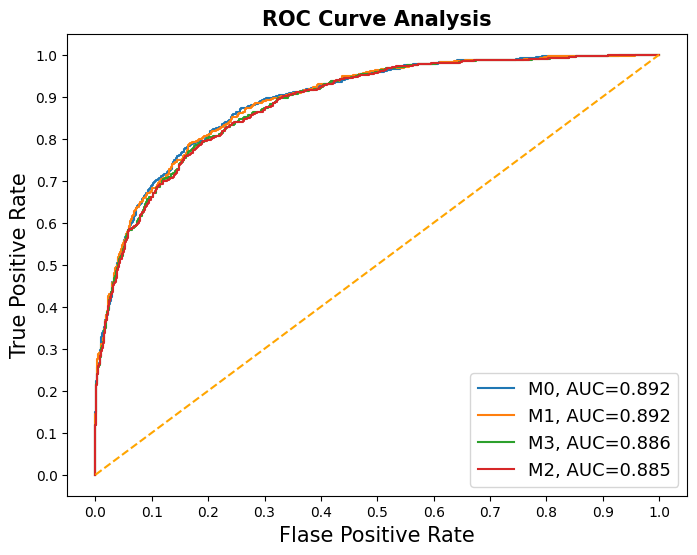

In [9]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)


_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(test_df,
                                    mode='validate.test',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

MEL_IDX = 6 # Check data exploration notebook

m_utility.roc_curve_comparation(classifiers, MEL_IDX, dataloader, device, val_times=4)

## With Extra Regularization

In [10]:
import os
import torch
import modular.models as m_models

classifiers = []
out_features = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for f in os.listdir('resnet18'):
  if f.endswith('.tar') and 'regularization' in f:
    model_path = f'resnet18/{f}'
    weights = torch.load(model_path)['model_state_dict']

    cls = m_models.ResNet18_Dropout_Melanoma(out_features)
    cls.load_state_dict(weights)
    cls = cls.to(device)
    classifiers.append((mapping_name[f], cls))

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is depre

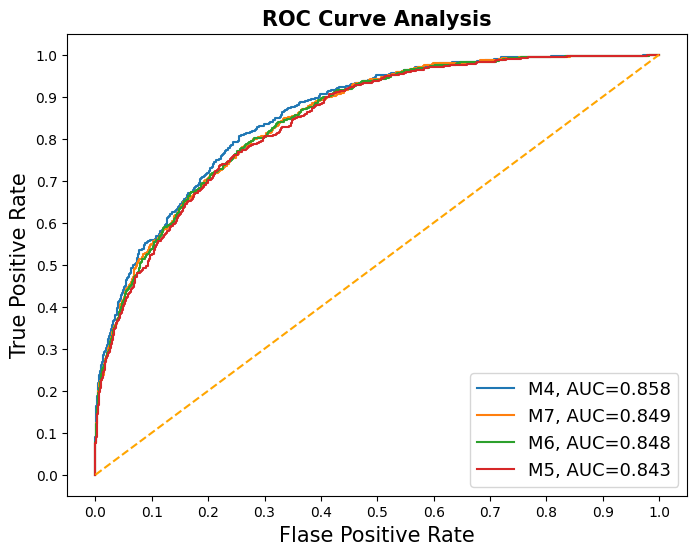

In [11]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)


_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(test_df,
                                    mode='validate.test',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

MEL_IDX = 6 # Check data exploration notebook

m_utility.roc_curve_comparation(classifiers, MEL_IDX, dataloader, device, val_times=4)

## Hole set of models

In [8]:
import os
import torch
import modular.models as m_models

classifiers = []
out_features = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for f in os.listdir('resnet18'):
  if f.endswith('.tar'):
    model_path = f'resnet18/{f}'
    weights = torch.load(model_path)['model_state_dict']

    if 'regularization' in f:
      cls = m_models.ResNet18_Dropout_Melanoma(out_features)
    else:
      cls = m_models.ResNet18_Melanoma(out_features)

    cls.load_state_dict(weights)
    cls = cls.to(device)
    classifiers.append((mapping_name[f], cls))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(metrics, ignore_index=True)
/content/modular/utility.py:160: FutureWarning: The frame.append method is depre

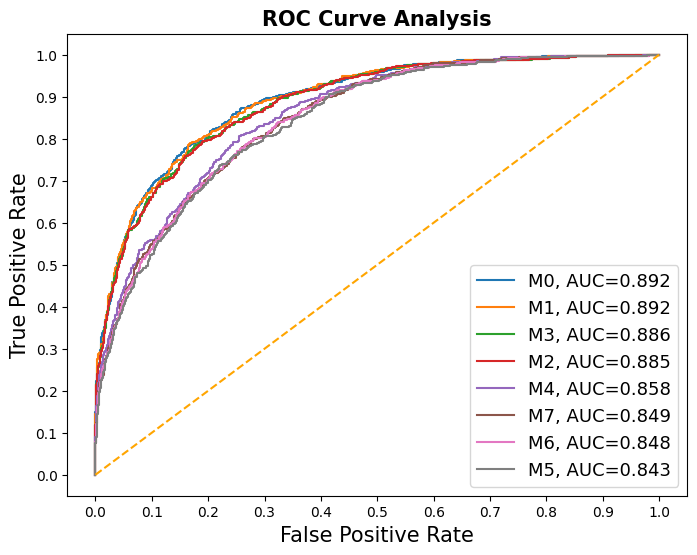

In [9]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)


_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(test_df,
                                    mode='validate.test',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

MEL_IDX = 6 # Check data exploration notebook

m_utility.roc_curve_comparation(classifiers, MEL_IDX, dataloader, device, val_times=4)